In [35]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


class Actions(Enum):
    Sell = 0
    Buy = 1


class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long


In [42]:


class TradingEnv2(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df, window_size):
        assert df.ndim == 2

        self.seed()
        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices)-1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None
        self.shares= None


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.
        self._total_profit = 1.  # unit
        self.shares=0
        self.balance=1000000#1 million
        self._first_rendering = True
        self.history = {}
        return self._get_observation()


    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.opposite()
        self._last_trade_tick = self._current_tick





        self._position_history.append(self._position)
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)

        return observation, step_reward, self._done, info


    def _get_observation(self):

        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]


    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)


    def render(self, mode='human'):

        def _plot_position(position, tick):
            color = None
            if position == Positions.Short:
                color = 'red'
            elif position == Positions.Long:
                color = 'green'
            if color:
                plt.scatter(tick, self.prices[tick], color=color)

        if self._first_rendering:
            self._first_rendering = False
            plt.cla()
            plt.plot(self.prices)
            start_position = self._position_history[self._start_tick]
            _plot_position(start_position, self._start_tick)

        _plot_position(self._position, self._current_tick)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )

        plt.pause(0.01)


    def render_all(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        short_ticks = [tick - 1 for tick in short_ticks]
        long_ticks = [tick - 1 for tick in long_ticks]

        plt.plot(long_ticks, self.prices[long_ticks], 'go')
        plt.plot(short_ticks, self.prices[short_ticks], 'ro')
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )


    def close(self):
        plt.close()


    def save_rendering(self, filepath):
        plt.savefig(filepath)


    def pause_rendering(self):
        plt.show()


    def _process_data(self):
        raise NotImplementedError


    def _calculate_reward(self, action):
        raise NotImplementedError


    def _update_profit(self, action):
        raise NotImplementedError


    def max_possible_profit(self):  # trade fees are ignored
        raise NotImplementedError

In [43]:
class StocksEnv2(TradingEnv2):

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2

        self.frame_bound = frame_bound
        super().__init__(df, window_size)

        self.trade_fee_bid_percent = 0.0 # unit
        self.trade_fee_ask_percent = 0.0  # unit


    def _process_data(self):
        prices = self.df.loc[:, 'Close'].to_numpy()

        prices[self.frame_bound[0] - self.window_size]  # validate index (TODO: Improve validation)
        prices = prices[self.frame_bound[0]-self.window_size:self.frame_bound[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = np.column_stack((prices, diff))

        return prices, signal_features


    def _calculate_reward(self, action):
        step_reward = 0

        trade=True
        if trade:

            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price
            current_nw= self.balance+self.shares*last_trade_price

            if action==1:
              self.balance-=last_trade_price
              self.shares+=1
              step_reward+=(self.balance+self.shares*current_price)-(current_nw)
            if action==0:
              self.balance+=last_trade_price
              self.shares-=1
              step_reward+=(self.balance+self.shares*current_price)-(current_nw)

        return step_reward


    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price
                self._total_profit = (shares * (1 - self.trade_fee_bid_percent)) * current_price


    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            if position == Positions.Long:
                current_price = self.prices[current_tick - 1]
                last_trade_price = self.prices[last_trade_tick]
                shares = profit / last_trade_price
                profit = shares * current_price
            last_trade_tick = current_tick - 1

        return profit

In [44]:
import pandas as pd

In [ ]:
test_data = pd.read_csv('/content/nift 50 july2019-jun2021.csv')#read the file that contains the required stock data

Preliminary Preprocessing of the given data


In [ ]:
print(test_data.isnull().sum())
print(len(test_data))

Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64
495


In [ ]:
test_data = test_data.dropna()

print(test_data.isnull().sum())
print(len(test_data))

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
493


In [ ]:

test_data['Date']=pd.to_datetime(test_data['Date'])
test_data.dtypes


Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [ ]:
test_data.set_index('Date',inplace=True)
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-07-01,11839.900391,11884.650391,11830.799805,11865.599609,11865.599609,278400.0
2019-07-02,11890.299805,11917.450195,11814.700195,11910.299805,11910.299805,363200.0
2019-07-03,11932.150391,11945.200195,11887.049805,11916.750000,11916.750000,340500.0
2019-07-04,11928.799805,11969.250000,11923.650391,11946.750000,11946.750000,333600.0
2019-07-05,11964.750000,11981.750000,11797.900391,11811.150391,11811.150391,530700.0
...,...,...,...,...,...,...
2021-06-23,15862.799805,15862.950195,15673.950195,15686.950195,15686.950195,287500.0
2021-06-24,15737.299805,15821.400391,15702.700195,15790.450195,15790.450195,316700.0
2021-06-25,15839.349609,15870.799805,15772.299805,15860.349609,15860.349609,314600.0


In [ ]:
test_data.drop(columns='Adj Close',inplace=True)
test_data

,Open,High,Low,Close,Volume
Date,,,,,
2019-07-01,11839.900391,11884.650391,11830.799805,11865.599609,278400.0
2019-07-02,11890.299805,11917.450195,11814.700195,11910.299805,363200.0
2019-07-03,11932.150391,11945.200195,11887.049805,11916.750000,340500.0
2019-07-04,11928.799805,11969.250000,11923.650391,11946.750000,333600.0
2019-07-05,11964.750000,11981.750000,11797.900391,11811.150391,530700.0
...,...,...,...,...,...
2021-06-23,15862.799805,15862.950195,15673.950195,15686.950195,287500.0
2021-06-24,15737.299805,15821.400391,15702.700195,15790.450195,316700.0
2021-06-25,15839.349609,15870.799805,15772.299805,15860.349609,314600.0


In [ ]:
!pip install stable_baselines3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 26.3 MB/s eta 0:00:00


In [ ]:
!pip install shimmy

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import DQN,A2C,PPO


In [ ]:
env_maker = lambda: StocksEnv2(test_data, 30, (30,len(test_data)-1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = DummyVecEnv([env_maker])

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
model = DQN('MlpPolicy', env, verbose=1)

Using cpu device


In [ ]:
model=model.load('/content/dqn_model.zip')#loadingthe weights of our pre trained model

In [ ]:
env = StocksEnv2(test_data, 30, (30,len(test_data)-1))
obs = env.reset()
while True:
    obs = obs[np.newaxis, ...]

    action, _states = model.predict(obs)

    obs, rewards, done, info = env.step(action)


    if done:
        print(env.balance)
        print(env.shares)
        print("info", info)
        break
#printing out the results after the test run (ignore total profit)
#here the total reward represents the increment in the net worth of the agent

1969324.1015560003
25
info {'total_reward': 309209.08688100055, 'total_profit': 1.1164349172503092, 'position': 1}


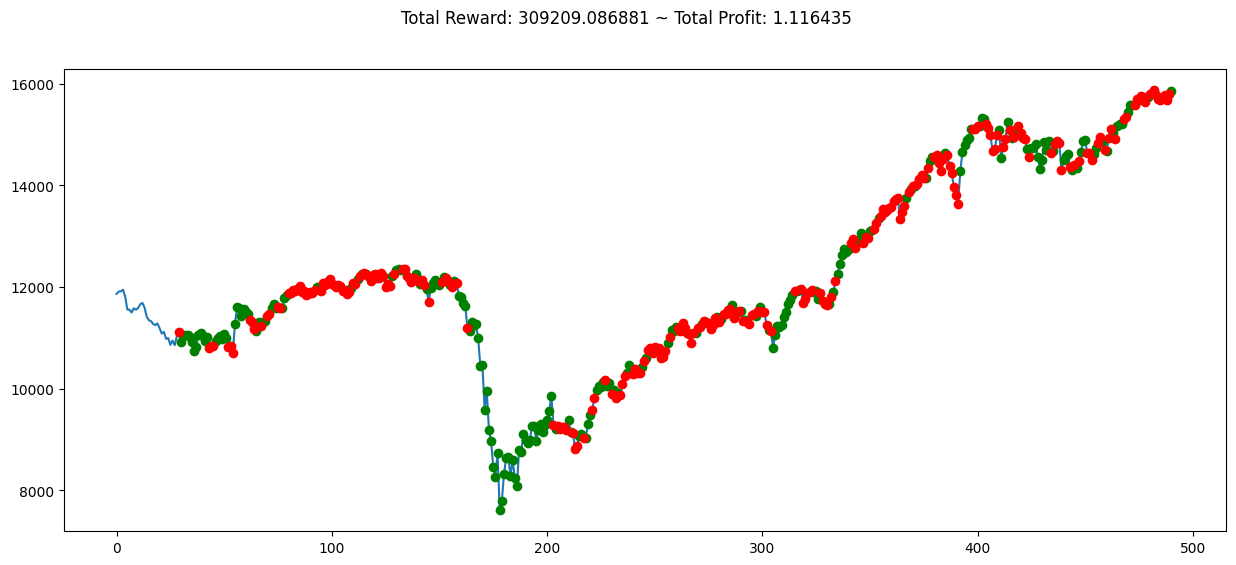

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [55]:
from keras.models import load_model


In [56]:
model = load_model('/content/lstm_weights.h5')

In [57]:
model.predict([[[1.02,1,1,0.25]]])

1/1 [==============================] - 0s 135ms/step


array([[11921.496]], dtype=float32)

In [58]:
import pandas as pd


In [59]:
df=pd.read_csv('/content/nift 50 july2019-jun2021.csv',index_col='Date',parse_dates=True,infer_datetime_format=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-07-01,11839.900391,11884.650391,11830.799805,11865.599609,11865.599609,278400.0
2019-07-02,11890.299805,11917.450195,11814.700195,11910.299805,11910.299805,363200.0
2019-07-03,11932.150391,11945.200195,11887.049805,11916.750000,11916.750000,340500.0
2019-07-04,11928.799805,11969.250000,11923.650391,11946.750000,11946.750000,333600.0
2019-07-05,11964.750000,11981.750000,11797.900391,11811.150391,11811.150391,530700.0
...,...,...,...,...,...,...
2021-06-23,15862.799805,15862.950195,15673.950195,15686.950195,15686.950195,287500.0
2021-06-24,15737.299805,15821.400391,15702.700195,15790.450195,15790.450195,316700.0
2021-06-25,15839.349609,15870.799805,15772.299805,15860.349609,15860.349609,314600.0


In [60]:
df = df.dropna()

print(df.isnull().sum())
print(len(df))

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
493


In [61]:
print('Dataframe Shape: ', df. shape)
print('Null Value Present: ', df.isnull().values.any())

Dataframe Shape:  (493, 6)
Null Value Present:  False


In [62]:
#Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [64]:
y_test=output_var[:].values.ravel()

In [65]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2019-07-01,0.501791,0.488367,0.518490,0.153727
2019-07-02,0.507952,0.492530,0.516558,0.200552
2019-07-03,0.513068,0.496053,0.525242,0.188018
2019-07-04,0.512659,0.499105,0.529635,0.184208
2019-07-05,0.517053,0.500692,0.514542,0.293043


In [66]:
X_test= feature_transform[:]

In [67]:
import numpy as np

In [68]:
X_test

,Open,High,Low,Volume
Date,,,,
2019-07-01,0.501791,0.488367,0.518490,0.153727
2019-07-02,0.507952,0.492530,0.516558,0.200552
2019-07-03,0.513068,0.496053,0.525242,0.188018
2019-07-04,0.512659,0.499105,0.529635,0.184208
2019-07-05,0.517053,0.500692,0.514542,0.293043
...,...,...,...,...
2021-06-23,0.993576,0.993311,0.979781,0.158752
2021-06-24,0.978234,0.988037,0.983232,0.174876
2021-06-25,0.990709,0.994307,0.991586,0.173716


In [69]:
testX =np.array(X_test)

In [70]:
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [71]:
y_pred= model.predict(X_test)

16/16 [==============================] - 0s 1ms/step


In [72]:
y_pred


array([[ 8213.131 ],
       [ 8310.689 ],
       [ 8330.513 ],
       [ 8340.789 ],
       [ 8500.362 ],
       [ 8243.166 ],
       [ 8081.202 ],
       [ 7993.5215],
       [ 7996.053 ],
       [ 8063.5996],
       [ 8067.9883],
       [ 8192.557 ],
       [ 8232.279 ],
       [ 8236.148 ],
       [ 8111.617 ],
       [ 8008.8877],
       [ 7950.968 ],
       [ 7862.6123],
       [ 7985.908 ],
       [ 7920.7866],
       [ 7885.9146],
       [ 7820.151 ],
       [ 7764.749 ],
       [ 7684.2603],
       [ 7682.9766],
       [ 7561.6484],
       [ 7594.8027],
       [ 7656.8916],
       [ 7606.1436],
       [ 7810.124 ],
       [ 7847.975 ],
       [ 7694.6387],
       [ 7662.7344],
       [ 7639.627 ],
       [ 7663.9688],
       [ 7720.1753],
       [ 7698.4595],
       [ 7602.3354],
       [ 7799.435 ],
       [ 7935.4004],
       [ 7788.0674],
       [ 7799.038 ],
       [ 7769.691 ],
       [ 7577.1216],
       [ 7512.3643],
       [ 7650.4243],
       [ 7591.981 ],
       [ 7556

In [73]:
import matplotlib.pyplot as plt

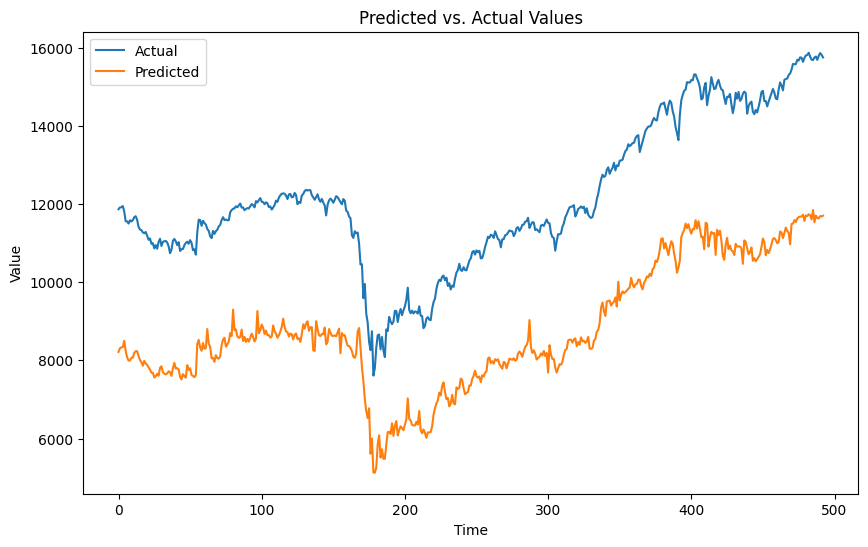

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()

In [76]:
env = StocksEnv2(df, 30, (30,len(df)-1))
obs = env.reset()
step=30
while True:
    obs = obs[np.newaxis, ...]
    action=(y_pred[step]>y_pred[step-1] and env.balance>0)



    obs, rewards, done, info = env.step(action)

    step+=1
    if done:
        print(env.balance)
        print(env.shares)
        print("info", info)
        break
#printing out the results after the test run (ignore total profit)
#here the total reward represents the increment in the net worth of the agent

589670.3027479989
81
info {'total_reward': 315178.49899299885, 'total_profit': 1.3528995048525605, 'position': 1}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
